## Predict next day's close price and then movement boolean 
### This is not a valid trading strategy, 
following along with two different tutorials and munging them together

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


2023-06-15 17:21:29.977024: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = yf.Ticker("TSLA").history(period="max")
# test that it works
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


In [3]:
df.shape

(3264, 7)

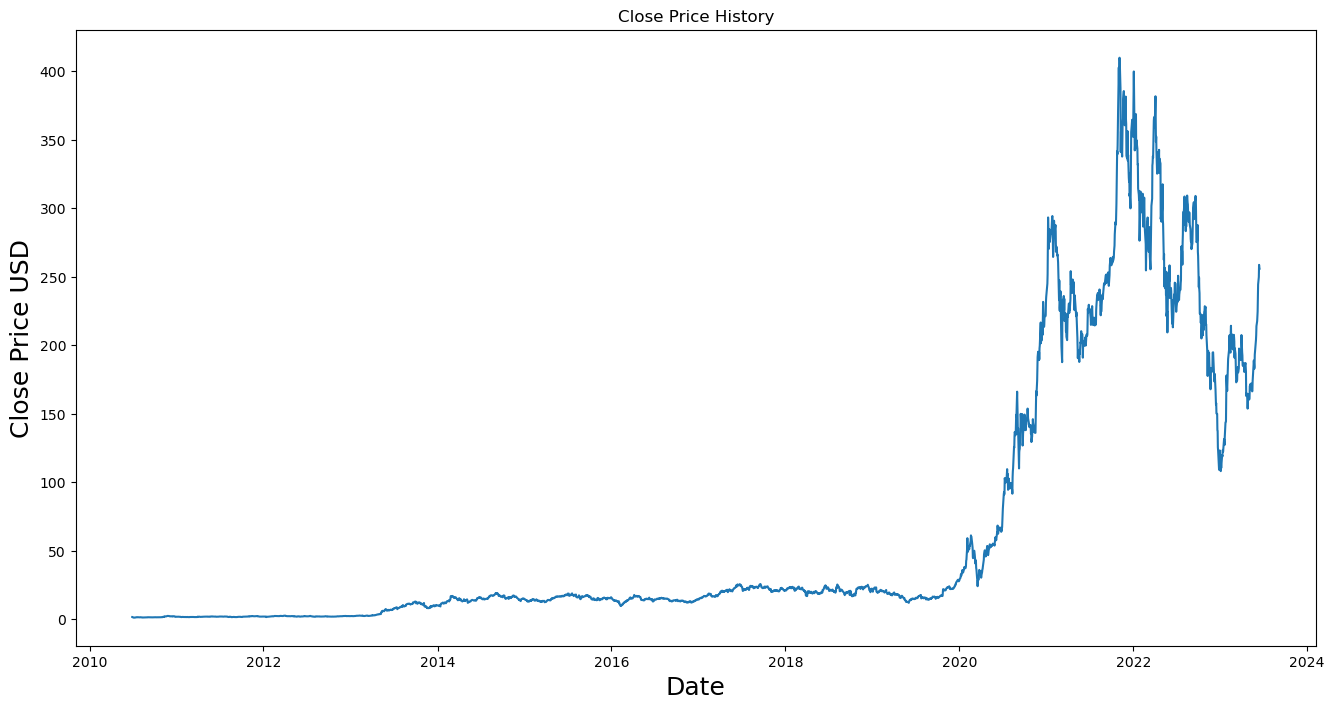

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.show()

In [5]:
close_data = df.filter(['Close']).copy()
close_data.head()


,Close
Date,
2010-06-29 00:00:00-04:00,1.592667
2010-06-30 00:00:00-04:00,1.588667
2010-07-01 00:00:00-04:00,1.464000
2010-07-02 00:00:00-04:00,1.280000
2010-07-06 00:00:00-04:00,1.074000


In [6]:
close_data["target"] = close_data["Close"].shift(-1)
close_data.dropna(inplace=True)
close_data.head()

,Close,target
Date,,
2010-06-29 00:00:00-04:00,1.592667,1.588667
2010-06-30 00:00:00-04:00,1.588667,1.464000
2010-07-01 00:00:00-04:00,1.464000,1.280000
2010-07-02 00:00:00-04:00,1.280000,1.074000
2010-07-06 00:00:00-04:00,1.074000,1.053333


In [7]:
def train_test_split(data, split):
    data = data.values
    split = math.floor(len(data) * split)
    return data[:split], data[split:]

In [8]:
train, test = train_test_split(close_data, 0.8)

In [9]:
print(len(train))
print(len(test))

2610
653


In [10]:
X_train = train[:, :-1]
y_train = train[:, -1]

In [11]:
from xgboost import XGBRegressor

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [12]:
# check true value
test[-1]

array([256.79000854, 255.8999939 ])

In [14]:
val = np.array(test[-1, 0]).reshape(1, -1)
pred = model.predict(val)
# predicted value
print(pred[0])

158.34244


In [15]:
def xgb_predict(train, val):
    train = np.array(train)
    X, y = train[:, :-1], train[:, -1]
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    
    model.fit(X, y)
    val = np.array(val).reshape(1, -1)
    pred = model.predict(val)
    return pred[0]

In [16]:
xgb_predict(train, test[-1, 0])

158.34244

In [17]:
from sklearn.metrics import mean_squared_error
# walk forward validation on test data

def validate(data, split):
    predictions = []
    train, test = train_test_split(data, split)
    history = [x for x in train]

    for i in range(len(test)):
        test_X, test_y = test[i, :-1], test[i, -1]
        pred = xgb_predict(history, test_X[0])
        predictions.append(pred)

        history.append(test[i])

    error = mean_squared_error(test[:, -1], predictions, squared=False)
    return error, test[:, -1], predictions

In [18]:
rmse, y, pred = validate(close_data, 0.8)
print(rmse)

14.094047904725521


In [20]:
# next close price prediction
pred[-1]

241.5737

## Swap to predicting if price will move up, predicting price doesn't truly reflect what we want to know

In [5]:
df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
# add tomorrow's close price as a column, grabbing the next row's close price
df["Next Close"] = df["Close"].shift(-1)
# this is our target, can we predict if tomorrow will be higher?
df["Price Higher"] = (df["Next Close"] > df["Close"]).astype(int)

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
train_data = df.iloc[:-100]
test_data = df.iloc[-100:]

predictors = ["Open", "High", "Low", "Close", "Volume"]
model.fit(train_data[predictors], train_data["Price Higher"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [7]:
from sklearn.metrics import precision_score

predictions = model.predict(test_data[predictors])

In [8]:
predictions = pd.Series(predictions, index=test_data.index)

In [9]:
precision_score(test_data["Price Higher"], predictions)

0.58

In [8]:
def prediction(train_data, test_data, predictors, model):
    model.fit(train_data[predictors], train_data["Price Higher"])
    predictions = model.predict(test_data[predictors])
    predictions = pd.Series(predictions, index=test_data.index, name="Predictions")
    actual_vs_predictions = pd.concat([test_data["Price Higher"], predictions], axis=1)
    return actual_vs_predictions

In [9]:
def backtest(data, model, predictors, start=250, step=25):
    results = []
    for i in range(start, len(data), step):
        train_data = data.iloc[:i]
        test_data = data.iloc[i:i+step]
        results.append(prediction(train_data, test_data, predictors, model))
    return pd.concat(results)

In [12]:
predictions = backtest(df, model, predictors)

In [13]:
predictions["Predictions"].value_counts()

1    1738
0    1275
Name: Predictions, dtype: int64

In [14]:
precision_score(predictions["Price Higher"], predictions["Predictions"])

0.5097813578826237

In [15]:
predictions["Price Higher"].value_counts() / predictions.shape[0]

1    0.519416
0    0.480584
Name: Price Higher, dtype: float64

In [10]:
# do more predictors improve accuracy?
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["Price Higher"]
    
    new_predictors+= [ratio_column, trend_column]

In [11]:
df = df.dropna(subset=df.columns[df.columns != "Next Close"])

In [12]:
df.head()

,Open,High,Low,Close,Volume,Next Close,Price Higher,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2014-06-19 00:00:00-04:00,15.258667,15.687333,15.133333,15.186000,131896500,15.306000,1,1.001473,1.0,1.019094,4.0,1.104864,30.0,1.305755,134.0,3.367118,516.0
2014-06-20 00:00:00-04:00,15.234667,15.419333,15.080000,15.306000,73558500,15.814667,1,1.003935,2.0,1.006285,4.0,1.112100,31.0,1.312219,134.0,3.383434,517.0
2014-06-23 00:00:00-04:00,15.300667,15.932667,15.214667,15.814667,116866500,15.500000,0,1.016345,2.0,1.028360,4.0,1.146291,32.0,1.351662,134.0,3.484822,518.0
2014-06-24 00:00:00-04:00,15.931333,16.125334,15.442000,15.500000,121138500,15.792667,1,0.989951,1.0,1.007174,3.0,1.121665,31.0,1.320951,133.0,3.404815,518.0
2014-06-25 00:00:00-04:00,15.536667,15.836667,15.349333,15.792667,87024000,15.706667,0,1.009353,1.0,1.017578,4.0,1.140236,32.0,1.342000,133.0,3.457924,519.0


In [13]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [14]:
# overwrite the predict function to use the new predictors
def predict(train_data, test_data, predictors, model):
    model.fit(train_data[predictors], train_data["Price Higher"])
    predicitions = model.predict_proba(test_data[predictors])[:,1]
    predicitions[predicitions >=.6] = 1
    predicitions[predicitions <.6] = 0
    predicitions = pd.Series(predicitions, index=test_data.index, name="Predictions")
    combined = pd.concat([test_data["Price Higher"], predicitions], axis=1)
    return combined

In [15]:
predictions = backtest(df, model, new_predictors)

In [16]:
predictions["Predictions"].value_counts()

1    1161
0     852
Name: Predictions, dtype: int64

In [17]:
precision_score(predictions["Price Higher"], predictions["Predictions"])

0.5202411714039621

In [24]:
predictions["Price Higher"].value_counts() / predictions.shape[0]

1    0.522106
0    0.477894
Name: Price Higher, dtype: float64

In [26]:
# better but still not great. 
predictions["Price Higher"]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices